In [1]:
import numpy as np
import regex as re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Query for type of data "Afstemning". The query returns (per default) the first 100 matches, as well as a  the "Sagstrin" and "Sag" and filter for "vedtaget" (true)
#old query
#url_sager = 'https://oda.ft.dk/api/Afstemning?$expand=Sagstrin/Sag&$filter=vedtaget eq true&$inlinecount=allpages'


# Gathering all the information
### Sitching together multiple queries from oda.ft
The data we are looking for is accesable via oda.ft, but can not be reached via a single query. The data is organized after a data structure described here, https://oda.ft.dk/Home/OdaModel , and in order to obtain information about what the specific politicans voted for, in relation to a specific law proposal, we need to combine and match the following queries:
- Query 1: Obtain all votings (afstemninger):
    - Get all law votings that has been passed, information about the laws, including the unique ID of each individual law
- Query 2: Obtain all individual vote IDs, for a given voting
    - For a given voting, get a list of the unique numerric actor IDs that has voted for a specific law (which is tied to a politican), as well as whether the vote was yes, no or absent
- Query 3: Obtain the relation between actor IDs and politicans
    - Get the map between numeric actor ID and entity, and match this to the voting IDs of query 2

### Query 1: Obtain all votings (afstemning) 
The query returns (per default) a json with 3 keys: 'metadata', 'value' and 'nextlink'
- the 'value' key contains a list of up 100 votings, each voting is a dict with 11 keys
- the 'nextlink' key contains a link to the next 100 votings, as well as the link for the next 100 and so forth

Filtering is done by expanding the "Sagstrin" and "Sag" keys of each voting and filtering for 3 things:
- "vedtaget" = true, the voting ended in approval
-  "sagstrin id = 17" = "3rd reading" meaning that this is the final processing of the law, if passed here, the law is implemented
-  "sag id = 3" = lovforslag, meaning that this is a law proposal (could be a voting for something else, like a budget)

In [3]:
url_sager = 'https://oda.ft.dk/api/Afstemning?$expand=Sagstrin/Sag&$filter=typeid eq 1 and vedtaget eq true and Sagstrin/typeid eq 17 and Sagstrin/Sag/typeid eq 3&$inlinecount=allpages'

In [4]:
#This function takes dict, extracts the next link, gets the new dict and appends it to the old dict

import requests

def get_all_pages(url):

    r = requests.get(url)

    sager = r.json()
    prev = r.json()

    while 'odata.nextLink' in prev:

        r = requests.get(prev['odata.nextLink'])
        sager['value'] += r.json()['value']
        prev = r.json()

    return sager

In [5]:
sager = get_all_pages(url_sager)
sager.keys()

dict_keys(['odata.metadata', 'odata.count', 'value', 'odata.nextLink'])

In [6]:
#checking if all sager have the same keys
test = [len(sager['value'][i].keys()) for i in range(len(sager['value']))]
np.unique(test)

array([10])

In [7]:
#Not needed any longer

#they don't, so we check how many sager have missing keys
#missing_keys = [i for i in range(len(sager['value'])) if len(sager['value'][i].keys()) != 10]
#issing_keys

In [8]:
#Not needed any longer 

#the above is only 14, so we remove those sager
#clean_sager = [sag for sag in sager['value'] if len(sag) == 10]
clean_sager = [sag for sag in sager['value']]

In [7]:
print(f'Hence we have a total of {len(clean_sager)} sager')

Hence we have a total of 3828 sager


In [9]:
clean_sager[0].keys()

dict_keys(['Sagstrin', 'id', 'nummer', 'konklusion', 'vedtaget', 'kommentar', 'mødeid', 'typeid', 'sagstrinid', 'opdateringsdato'])

In [14]:
import json
#format dict to json
#json_sager = json.dumps([clean_sager[0]])
#parsed = json.loads(json_sager)
#print(json.dumps(parsed, indent=4))

Each voting is 3 layered nested dict with the following structure:
- Top layer, voting: Information about the voting, unique ID of the voting, whether it was approved, date of approval etc. as seen below

In [15]:
clean_sager[0].keys()

dict_keys(['Sagstrin', 'id', 'nummer', 'konklusion', 'vedtaget', 'kommentar', 'mødeid', 'typeid', 'sagstrinid', 'opdateringsdato'])

- Mid layer, "sagstrin" / "case stage": Nested dict within the voting, about the specific case process, what type of process is this (voting), what date, where was it held etc.,

In [16]:
clean_sager[0]['Sagstrin'].keys()

dict_keys(['Sag', 'id', 'titel', 'dato', 'sagid', 'typeid', 'folketingstidendeurl', 'folketingstidende', 'folketingstidendesidenummer', 'statusid', 'opdateringsdato'])

- Bottom layer, 'sag' / 'case': Nested dict within 'sagstrin, information about the specific case, in this case a law, what the law is about, the law number, category and a range of other values relating to the law itself. 

In [17]:
clean_sager[0]['Sagstrin']['Sag'].keys()

dict_keys(['id', 'typeid', 'kategoriid', 'statusid', 'titel', 'titelkort', 'offentlighedskode', 'nummer', 'nummerprefix', 'nummernumerisk', 'nummerpostfix', 'resume', 'afstemningskonklusion', 'periodeid', 'afgørelsesresultatkode', 'baggrundsmateriale', 'opdateringsdato', 'statsbudgetsag', 'begrundelse', 'paragrafnummer', 'paragraf', 'afgørelsesdato', 'afgørelse', 'rådsmødedato', 'lovnummer', 'lovnummerdato', 'retsinformationsurl', 'fremsatundersagid', 'deltundersagid'])

#### Save relevant variables as dataframe
We save all the relevant fields from this query into our law dataframe

In [9]:
import pandas as pd
import numpy as np

def law_info(data):
    df = pd.DataFrame()

    df['afstemnings_id'] = [x['id'] for x in data]
    df['sagstrin_id'] = [x['sagstrinid'] for x in data]
    df['vedtaget'] = [x['vedtaget'] for x in data]
    df['dato_afst_opd'] = [x['opdateringsdato'] for x in data]
    df['dato_sagstrin'] = [x['Sagstrin']['dato'] for x in data]
    df['dato_sag_opd'] = [x['Sagstrin']['Sag']['opdateringsdato'] for x in data]
    df['sag_id'] = [x['Sagstrin']['Sag']['id'] for x in data]
    df['titel']= [x['Sagstrin']['Sag']['titel'] for x in data]
    df['titel_kort'] = [x['Sagstrin']['Sag']['titelkort'] for x in data]
    df['lovnummer_num'] = [x['Sagstrin']['Sag']['nummernumerisk'] for x in data]
    df['lovnummer'] = [x['Sagstrin']['Sag']['nummer'] for x in data]
    df['resume']= [x['Sagstrin']['Sag']['resume'] for x in data]
    df['periode_id']= [x['Sagstrin']['Sag']['periodeid'] for x in data]

    return df
        
law_info = law_info(clean_sager)
law_info.head()

,afstemnings_id,sagstrin_id,vedtaget,dato_afst_opd,dato_sagstrin,dato_sag_opd,sag_id,titel,titel_kort,lovnummer_num,lovnummer,resume,periode_id
0,2,4849,True,2014-09-09T09:25:05.717,2014-09-09T09:15:00,2017-12-05T19:51:10.197,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32
1,4,18370,True,2018-01-25T10:25:25.64,2012-11-06T00:00:00,2018-09-27T11:27:48.387,5904,Forslag til lov om akutjob og jobpræmie til ar...,Om akutjob.,46,L 46,"Med loven etableres en midlertidig ordning, så...",31
2,5,4849,True,2017-08-10T12:57:52.27,2014-09-09T09:15:00,2017-12-05T19:51:10.197,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32
3,9,4856,True,2017-08-10T12:57:52.237,2014-06-11T09:00:00,2017-12-05T19:51:10.547,1451,Forslag til lov om ændring af lov om trafiksel...,Om Region Nordjyllands overtagelse af statens ...,136,L 136 B,"Med loven åbnes der mulighed for, at Region No...",32
4,10,2500,True,2017-08-10T12:57:52.237,2014-06-11T09:00:00,2017-12-05T19:47:57.27,780,Forslag til lov om projektering af nyanlæg og ...,Om nyanlæg og hastighedsopgraderinger af jernb...,172,L 172,"Loven indeholder bemyndigelse til, at transpor...",32


### Query 2: Obtain individual IDs in relation to votings (aktør ID @ afstemning) 

In [10]:
#This function takes an id for a vote and collects all the votes for that vote


def get_all_votes(id):
    url = f'https://oda.ft.dk/api/Afstemning({id})/Stemme?$inlinecount=allpages'
    r = requests.get(url)
    votes = r.json()
    prev = r.json()
    while 'odata.nextLink' in prev:
        r = requests.get(prev['odata.nextLink'])
        votes['value'] += r.json()['value']
        prev = r.json()
        
    return votes


votes_test = get_all_votes(clean_sager[0]['id'])

For each voting ID (a law) the function returns a list of dicts, where each dict is equavalent to a vote for that speifici law, and contains the ID of the voter (aktørid) and what was voted ("afstemningsid), along with a few other variables.

In [12]:
votes_test['value'][0]

{'id': 180,
 'typeid': 1,
 'afstemningid': 2,
 'aktørid': 158,
 'opdateringsdato': '2014-09-09T09:25:05.717'}

### Save relevant variables as a DF
Using the function we just wrote, and applying it to the list of all laws, we create a DF that contains a row for each vote defined by the unique ID of that voting, along with a dict containing all the votes for that law processing.

In [11]:
#THIS FUNCTION TAKES 10+ MINUTES TO RUN - INSTEAD; SCROLL DOWN TO NEXT CELL AND LOAD DATAFRAME FROM PICKLE

#This function takes in a df of each vote and makes a dataframe of all the votes for each vote
def votes_df(voting_df):
    df = pd.DataFrame()

    #typeid: 1=ja, 2=nej, 3=blank, 4=fraværende

    df["afstemnings_id"] = voting_df["afstemnings_id"].values
    df["votes_combined_info"] = [get_all_votes(x)['value'] for x in voting_df['afstemnings_id']] #creates a dict
    

    return df

#vote_df = votes_df(law_info)

In [12]:
#save df as pickle
#vote_df.to_pickle('vote_df_python3-7.pkl')

In [13]:
#load vote_df from pickle
vote_df = pd.read_pickle('vote_df_python3-7.pkl')

In [14]:
vote_df.head()

,afstemnings_id,votes_combined_info
0,2,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '..."
1,4,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4..."
2,5,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5..."
3,9,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9..."
4,10,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1..."


### Query 3: Obtain a map between the numerical actor id (aktørid) of all politicians that has voted, and onto the actual name of the politician and the party of which they belong

#### Create a function that returns the name and party of a politican, given the unique actor-id and relevant period ids

In [15]:
import requests

def get_politician_info(id: int, period_id_list: list):
    
    politician = {}
    politician['party'] = {}

    #First, Look up name of politician given the actor id, and add the name to the politician dict
    name_url = f'https://oda.ft.dk/api/Akt%C3%B8r({id})'
    try:
        response = requests.get(name_url)
        data_json = response.json()
        try:
            politician['navn'] = data_json['fornavn'] + ' ' + data_json['efternavn']
        except:
            politician['navn'] = 'unknown'
    except:
        print('WARNING: name URL not found for id:', id)
        print(name_url)
        politician['navn'] = 'invalid_url'
        
    #Next, look up the party of a given actor, in a given period, add the party of each period as a dict, to the politician dict
    for periode_id in period_id_list:
        party_url = f'https://oda.ft.dk/api/AktørAktør?$expand=FraAktør,TilAktør/Aktørtype&$filter=FraAktør/id eq {id} and TilAktør/Aktørtype/type eq \'Folketingsgruppe\' and TilAktør/periodeid eq {periode_id}&$inlinecount=allpages'

        try:
            response = requests.get(party_url)
            data_json = response.json()
                
            try:
                party = data_json['value'][0]['TilAktør']['navn']
                politician['party'][periode_id] = party
            except:
                print('party not found for id:', id, 'in period:', periode_id)
                politician['party'][periode_id] = 'unknown'
                print(party_url)
        except:
                print('WARNING: party URL not found for id:', id, 'in period:', periode_id)
                politician['party'][periode_id] = 'invalid_url'
                print(party_url)
    
            
    return politician


In [16]:
#To look up the info of a politician we need a collection of all the politician ids as wel as the period ids of which each politician was part of the parlaiment

def get_all_politician_periods(law_df):
    politician_periode_id_dict = dict()
    for index, row in law_df.iterrows():
        for vote in row['votes_combined_info']:
            if vote['aktørid'] in politician_periode_id_dict:
                if row['periode_id'] not in politician_periode_id_dict[vote['aktørid']]:
                    politician_periode_id_dict[vote['aktørid']].append(row['periode_id'])
            else:
                politician_periode_id_dict[vote['aktørid']] = [row['periode_id']]
    return politician_periode_id_dict
        
#politician_periode_id_dict = get_all_politician_periods(law_info)

In [49]:
def get_all_politician_info(politician_id_period: dict):
    politician_df = pd.DataFrame(columns=['politician_name', 'party', 'politician_id'])
    for id, period_id_list in politician_id_period.items():
        politician = get_politician_info(id, period_id_list)
        politician_df = politician_df.append({'politician_name': politician['navn'], 'party': politician['party'], 'politician_id': id}, ignore_index=True)
    return politician_df

In [17]:
#Takes 4-6 minutes to run, instead, load the pickle below
#politician_df = get_all_politician_info(politician_periode_id_dict)

In [18]:
#save df as pickle
#politician_df.to_pickle('politician_df_python3-7.pkl')
politician_df = pd.read_pickle('politician_df_python3-7.pkl')

In [19]:
politician_df.head()

,politician_name,party,politician_id
0,Eigil Andersen,"{32: 'Socialistisk Folkeparti', 31: 'Socialist...",158
1,Kim Andersen,"{32: 'Venstre, Danmarks Liberale Parti', 31: '...",126
2,Tom Behnke,"{32: 'Det Konservative Folkeparti', 31: 'Det K...",71
3,Liselott Blixt,"{32: 'Dansk Folkeparti', 31: 'Dansk Folkeparti...",50
4,Erling Bonnesen,"{32: 'Venstre, Danmarks Liberale Parti', 31: '...",49


In [20]:
#print the unique parties in the values of the dicts in the party column
unique_parties = set()
for party_dict in politician_df['party']:
    for party in party_dict.values():
        unique_parties.add(party)
print(unique_parties)

{'Uden for folketingsgrupperne - Jens Henrik Thulesen Dahl', 'Uden for folketingsgrupperne - Uffe Elbæk', 'Uden for folketingsgrupperne - Jens Rohde', 'Uden for folketingsgrupperne - Kristian Thulesen Dahl', 'Uden for folketingsgrupperne - Christian H. Hansen', 'Uden for folketingsgrupperne - Peter Skaarup', 'Ny Alliance', 'Uden for folketingsgrupperne - Anders Møller', 'Socialistisk Folkeparti', 'Alternativet', 'Sambandsflokkurin', 'Uden for folketingsgrupperne - Pia Christmas-Møller', 'Uden for folketingsgrupperne - Naser Khader', 'Uden for folketingsgrupperne - Orla Østerby', 'Uden for folketingsgrupperne - Peter Brixtofte', 'Uden for folketingsgrupperne - Søren Espersen', 'unknown', 'Uden for folketingsgrupperne - Lise Bech', 'Uden for folketingsgrupperne - Rasmus Nordqvist', 'Venstre, Danmarks Liberale Parti', 'Uden for folketingsgrupperne - Sikandar Siddique', 'Inuit Ataqatigiit', 'Nye Borgerlige', 'Kristendemokraterne', 'Uden for folketingsgrupperne - Hans Kristian Skibby', 'Lib

In [24]:
#Clean the parties that are called "Uden for Folketingsgrupperne- #name of politician" to just be "Uden for folketingsgrupperne"
#And that we have both a party called "Det Radikale Venstre" and another "Radikale Venstre"

for party_dict in politician_df['party']:
    for key, party in party_dict.items():
        #use regex to search for strings that contain the sentence "Uden for folketingsgrupperne"
        if re.search(r'Uden for folketingsgrupperne', party):
            party_dict[key] = 'Uden for folketingsgrupperne'
        if re.search(r'Radikale Venstre', party):
            party_dict[key] = 'Radikale Venstre'



In [25]:
#write the politician_df to a pickle
politician_df.to_pickle('politician_df_python3-7.pkl')

In [26]:
#print the unique parties in the values of the dicts in the party column
unique_parties = set()
for party_dict in politician_df['party']:
    for party in party_dict.values():
        unique_parties.add(party)
print(unique_parties)

{'Ny Alliance', 'Sambandsflokkurin', 'Socialistisk Folkeparti', 'Alternativet', 'unknown', 'Venstre, Danmarks Liberale Parti', 'Inuit Ataqatigiit', 'Nye Borgerlige', 'Kristendemokraterne', 'Liberal Alliance', 'Enhedslisten', 'Fólkaflokkurin', 'Uden for folketingsgrupperne', 'Tjóðveldisflokkurin', 'Radikale Venstre', 'Socialdemokratiet', 'Nunatta Qitornai', 'Det Konservative Folkeparti', 'Tjóðveldi', 'Siumut', 'Javnaðarflokkurin', 'Dansk Folkeparti'}


In [16]:
#check if there are any ids where the URL was not found
#print(f"Any reqyests that failed due to URL error? {politican_df['party'].isin(['invalid_url']).any()}")
#print(f"Number of politicians where we have not managed to fetch the name {politican_df['politician_name'].value_counts()['unknown']}")
#Count number of politicians with no party found

# Summary and further cleaning
#### We now have the following 3 dataframes:

In [146]:
#A dataframe containing every single passed law and its information
law_info.head()

,afstemnings_id,sagstrin_id,vedtaget,dato_afst_opd,dato_sagstrin,dato_sag_opd,sag_id,titel,titel_kort,lovnummer_num,lovnummer,resume,periode_id,votes_combined_info
0,2,4849,True,2014-09-09T09:25:05.717,2014-09-09T09:15:00,2017-12-05T19:51:10.197,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '..."
1,4,18370,True,2018-01-25T10:25:25.64,2012-11-06T00:00:00,2018-09-27T11:27:48.387,5904,Forslag til lov om akutjob og jobpræmie til ar...,Om akutjob.,46,L 46,"Med loven etableres en midlertidig ordning, så...",31,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4..."
2,5,4849,True,2017-08-10T12:57:52.27,2014-09-09T09:15:00,2017-12-05T19:51:10.197,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5..."
3,9,4856,True,2017-08-10T12:57:52.237,2014-06-11T09:00:00,2017-12-05T19:51:10.547,1451,Forslag til lov om ændring af lov om trafiksel...,Om Region Nordjyllands overtagelse af statens ...,136,L 136 B,"Med loven åbnes der mulighed for, at Region No...",32,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9..."
4,10,2500,True,2017-08-10T12:57:52.237,2014-06-11T09:00:00,2017-12-05T19:47:57.27,780,Forslag til lov om projektering af nyanlæg og ...,Om nyanlæg og hastighedsopgraderinger af jernb...,172,L 172,"Loven indeholder bemyndigelse til, at transpor...",32,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1..."


In [147]:
#A dataframe containing a dict with the unique votes for each law, related to the numerical actor IDs of the politicians that voted
vote_df.head()

,afstemnings_id,votes_combined_info
0,2,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '..."
1,4,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4..."
2,5,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5..."
3,9,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9..."
4,10,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1..."


In [148]:
#A dataframe containing the unique actor IDs of each politican, linked to their their name and party (except for the politicians where we could not find the party)
politician_df.head()

,politician_name,party,politician_id
0,Eigil Andersen,"{32: 'Socialistisk Folkeparti', 31: 'Socialist...",158
1,Kim Andersen,"{32: 'Venstre, Danmarks Liberale Parti', 31: '...",126
2,Tom Behnke,"{32: 'Det Konservative Folkeparti', 31: 'Det K...",71
3,Liselott Blixt,"{32: 'Dansk Folkeparti', 31: 'Dansk Folkeparti...",50
4,Erling Bonnesen,"{32: 'Venstre, Danmarks Liberale Parti', 31: '...",49


In [149]:
#We decide to add the votes_combined_info column to the law_info dataframe
law_info['votes_combined_info'] = vote_df['votes_combined_info']

#### Cleaning 1: Some laws lack matched individual votes

By plotting a histogram of the different vote categories, we noticed a few problems...

First, by plotting yes votes for passed laws, we would expect there always to be more than 0 vores. However, a number of passed laws seem to have 0 yes votes associated, this can not be true. By looking further into the data, it appears that a number of laws - for unknown reasons - simply does not contain the data of what the individual actors voted. We will remove these laws.


In [150]:
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 1 (yes)
yes_votes = [len([x for x in y if x['typeid'] == 1]) for y in vote_df['votes_combined_info']]

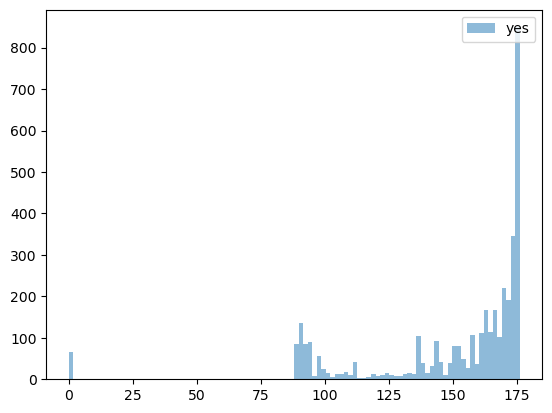

In [151]:
#plot a histogram of the number of yes votes, no votes, absent votes and blank votes for each law
plt.hist(yes_votes, bins=100, alpha=0.5, label='yes')
plt.legend(loc='upper right')
plt.show()

In [152]:
#count the total number of rows of the law_info dataframe where the votes_combined info column contains an empty list
print(f"Number of laws with no votes: {len(law_info[law_info['votes_combined_info'].map(len) == 0])}")

Number of laws with no votes: 66


In [153]:
#Remove the rows where the votes_combined_info column contains an empty list, and create a new copy of the dataframes
df_law_clean = law_info[law_info['votes_combined_info'].map(len) != 0].copy()
df_votes_clean = vote_df[vote_df['votes_combined_info'].map(len) != 0].copy()

#### Cleaning 2: Absent votes does not mean no
As the plot below shows, there´s generally between 90-115 yes votes, whereas the remainder of 60-80 are absent.

It turns out, there is an agreement between parties, that if it is known that one coalliation has enough votes to pass a law, the parties across the coalliations agree as to only send a representative quantity of politicians to do the actual voting. The remainder of politicians refrain from voting thereby getting the "absent" voting label. This does however NOT mean that the absent politician disagreed with a given law, rather it typically means that a given politican actually agree with the general line of voting of his/her party. 



In [154]:
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 1 (yes)
yes_votes = [len([x for x in y if x['typeid'] == 1]) for y in df_law_clean['votes_combined_info']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 2 (no)
no_votes = [len([x for x in y if x['typeid'] == 2]) for y in df_law_clean['votes_combined_info']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 3 (absent)
absent_votes = [len([x for x in y if x['typeid'] == 3]) for y in df_law_clean['votes_combined_info']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 4 (blank)
blank_votes = [len([x for x in y if x['typeid'] == 4]) for y in df_law_clean['votes_combined_info']]

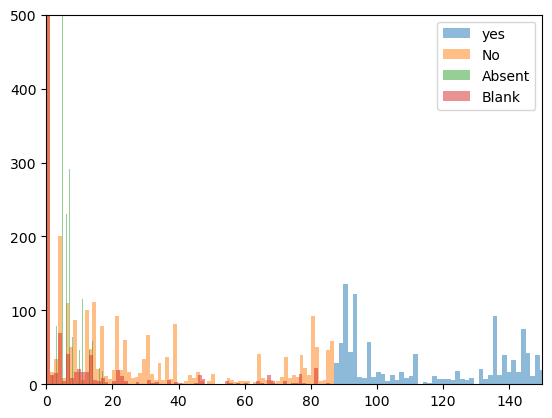

In [155]:
#plot a histogram of the number of yes votes, no votes, absent votes and blank votes for each law
#Only plot the y axis up to 500 as there are more than 3000 instances of no and blank votes
plt.hist(yes_votes, bins=75, alpha=0.5, label='yes')
plt.hist(no_votes, bins=75, alpha=0.5, label='No')
plt.hist(absent_votes, bins=75, alpha=0.5, label='Absent')
plt.hist(blank_votes, bins=75, alpha=0.5, label='Blank')
plt.ylim(0,500)
plt.xlim(0,150)
plt.legend(loc='upper right')
plt.show()


To solve the problem of absent votes, we will make the assumption, that for a given voting, if a politican has an "absent" vote, we will instead assign the most common type of vote from the party of this politician.

For any given voting, if the entire party voted absent, the votes are retained as absent.

The problem is further complexed by the challenge that some politicians change political party, hence we also need to consider a time-dimension when we do the mapping.

In [156]:
#copy the votes_df dataframe to a new dataframe where we will combine the politician data, and infer the type of vote for all the absent votes
df_votes_politicians_clean = df_votes_clean.copy()

In [157]:
df_votes_politicians_clean['periode_id'] = df_law_clean['periode_id']
df_votes_politicians_clean.head()

,afstemnings_id,votes_combined_info,periode_id
0,2,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '...",32
1,4,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4...",31
2,5,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5...",32
3,9,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9...",32
4,10,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1...",32


In [158]:
#For each index in the vote_df votes_combined_info column, add a new key called "party" and assign the value of the party by matching the id with the politican_df dataframe

for index, row in df_votes_politicians_clean.iterrows():
    for i in range(len(row['votes_combined_info'])):
        matched_politician = politician_df[politician_df['politician_id'] == row['votes_combined_info'][i]['aktørid']]
    
        #row['votes_combined_info'][i]['party'] = matched_politician['party'].values[0]
        #Find the party by looking up in the df_votes_politicians dataframe with the matched actor ID and the period ID
        try:
            party = matched_politician['party'].values[0][row['periode_id']]
        except:
            print(f"Could not match periode ID key {row['periode_id']} for actor ID {row['votes_combined_info'][i]['aktørid']}")	
            print(f"This person: {matched_politician}")
        if party == 'uknown':
            print(f"No party for actor id: {row['votes_combined_info'][i]['aktørid']}")
            print(f"No party for {matched_politician['politician_name'].values[0]}, in period {row['periode_id']}, party: {party}")
        row['votes_combined_info'][i]['party'] = party
        row['votes_combined_info'][i]['name'] = matched_politician['politician_name'].values[0]



In [159]:
#Save the combined dataframe using pickle
import pickle
with open('df_votes_politicians_clean.pickle', 'wb') as f:
    pickle.dump(df_votes_politicians_clean, f)

In [160]:
#Function that returns the majority typeid for each party for a given law
def get_majority_typeid_for_party(law):
    #Create a dict with the party as key and the typeid as value
    party_typeid_dict = {}
    for vote in law:
        #Do not include absent votes
        if vote['typeid'] != 3:
            #If the party is not already in the dict, add it
            if vote['party'] not in party_typeid_dict:
                party_typeid_dict[vote['party']] = [vote['typeid']]
            #If the party is already in the dict, append the typeid to the list of typeids
            else:
                party_typeid_dict[vote['party']].append(vote['typeid'])
    #Create a dict with the party as key and the majority typeid as value
    party_majority_typeid_dict = {}
    for party in party_typeid_dict:
        #Get the most common typeid for each party
        party_majority_typeid_dict[party] = max(set(party_typeid_dict[party]), key=party_typeid_dict[party].count)
    return party_majority_typeid_dict

#create a new column in the votes_df_combined dataframe called majority_typeid_for_party
df_votes_politicians_clean['majority_party_vote'] = [get_majority_typeid_for_party(law) for law in df_votes_politicians_clean['votes_combined_info']]

In [161]:
df_votes_politicians_clean.head()

,afstemnings_id,votes_combined_info,periode_id,majority_party_vote
0,2,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '...",32,"{'Socialistisk Folkeparti': 1, 'Venstre, Danma..."
1,4,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4...",31,"{'Socialistisk Folkeparti': 1, 'Socialdemokrat..."
2,5,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5...",32,"{'Socialistisk Folkeparti': 1, 'Venstre, Danma..."
3,9,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9...",32,"{'Dansk Folkeparti': 4, 'Socialistisk Folkepar..."
4,10,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1...",32,"{'Dansk Folkeparti': 1, 'Socialistisk Folkepar..."


In [162]:
#create a new column in the votes_df_combined dataframe called votes_adjusted that is a copy of the votes_combined_info column
#For each row in the votes_df_combined dataframe, check each element in the votes_adjusted info
#if the typeid = 3 (absent), then replace the typeid with the majority typeid for that party

df_votes_politicians_clean['votes_adjusted'] = df_votes_politicians_clean['votes_combined_info'].copy()
for index, row in df_votes_politicians_clean.iterrows():
    for i in range(len(row['votes_adjusted'])):
        if row['votes_adjusted'][i]['typeid'] == 3:
            #if the party is in the dict (in case there are no majority vote other than absent for that party, retain absent vote)
            if row['votes_adjusted'][i]['party'] in row['majority_party_vote'] and row['votes_adjusted'][i]['party'] != 'uknown' and row['votes_adjusted'][i]['party'] != 'Uden for folketingsgrupperne':
                row['votes_adjusted'][i]['typeid'] = row['majority_party_vote'][row['votes_adjusted'][i]['party']]

In [163]:
df_votes_politicians_clean.head()

,afstemnings_id,votes_combined_info,periode_id,majority_party_vote,votes_adjusted
0,2,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '...",32,"{'Socialistisk Folkeparti': 1, 'Venstre, Danma...","[{'id': 180, 'typeid': 1, 'afstemningid': 2, '..."
1,4,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4...",31,"{'Socialistisk Folkeparti': 1, 'Socialdemokrat...","[{'id': 850407, 'typeid': 1, 'afstemningid': 4..."
2,5,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5...",32,"{'Socialistisk Folkeparti': 1, 'Venstre, Danma...","[{'id': 164665, 'typeid': 1, 'afstemningid': 5..."
3,9,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9...",32,"{'Dansk Folkeparti': 4, 'Socialistisk Folkepar...","[{'id': 163591, 'typeid': 4, 'afstemningid': 9..."
4,10,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1...",32,"{'Dansk Folkeparti': 1, 'Socialistisk Folkepar...","[{'id': 163770, 'typeid': 1, 'afstemningid': 1..."


In [164]:
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 1 (yes)
yes_votes = [len([x for x in y if x['typeid'] == 1]) for y in df_votes_politicians_clean['votes_combined_info']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 2 (no)
no_votes = [len([x for x in y if x['typeid'] == 2]) for y in df_votes_politicians_clean['votes_combined_info']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 3 (absent)
absent_votes = [len([x for x in y if x['typeid'] == 3]) for y in df_votes_politicians_clean['votes_combined_info']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 4 (blank)
blank_votes = [len([x for x in y if x['typeid'] == 4]) for y in df_votes_politicians_clean['votes_combined_info']]

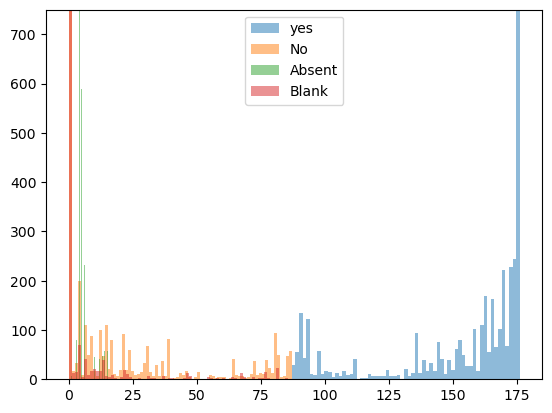

In [165]:
#plot a histogram of the number of yes votes, no votes, absent votes and blank votes for each law
#Only plot the y axis up to 500 as there are more than 3000 instances of no and blank votes
plt.hist(yes_votes, bins=75, alpha=0.5, label='yes')
plt.hist(no_votes, bins=75, alpha=0.5, label='No')
plt.hist(absent_votes, bins=75, alpha=0.5, label='Absent')
plt.hist(blank_votes, bins=75, alpha=0.5, label='Blank')
plt.ylim(0,750)
plt.legend(loc='upper center')
plt.show()


 It is perculiar that there seem to be large "spike" of the number of absent votes per law around 5-8 votes per processing, we look into where the majority of absent votes come from. This is after we have adjusted absent votes so that they are similar to the voting that the members of the similar party vote.

In [166]:
absent_dict = {}
for votings in df_votes_politicians_clean['votes_adjusted']:
    for vote in votings:
        if vote['typeid'] == 3:
            if vote['party'] not in absent_dict:
                absent_dict[vote['party']] = 1
            #If the party is already in the dict, append the typeid to the list of typeids
            else:
                absent_dict[vote['party']] += 1

absent_dict

{'Uden for folketingsgrupperne': 5538,
 'Sambandsflokkurin': 2176,
 'Javnaðarflokkurin': 2280,
 'Siumut': 3027,
 'Inuit Ataqatigiit': 3710,
 'Tjóðveldisflokkurin': 1461,
 'Kristendemokraterne': 413,
 'Liberal Alliance': 130,
 'Enhedslisten': 22,
 'unknown': 107,
 'Tjóðveldi': 931,
 'Fólkaflokkurin': 583,
 'Ny Alliance': 207,
 'Nunatta Qitornai': 219,
 'Alternativet': 214,
 'Nye Borgerlige': 24}

This seems reasonable, the vast majority of "pure" absent votes (i.e. entire party voted absent) stem from politicians when they had left a party and may not even bother to vote, along with the the north-atlantern mandates such as Sambandsflokkurin, Javnaðarflokkurin, Inuit Ataqatigiit and Tjóðveldi where there is a precedens that these parties refain from votin on many topics that does not affect Greenland or the Faroe Islands.

## Making a network
We merge the column of votings for each law, and as we will be matching afstemnings_id with aktør_id there is a potential conflict, because these integer values overlap (there are laws with the same ID as actors). For that reason we will add a new law_id column with a prefix. 

In [167]:
df_law_clean['votes_adjusted'] = df_votes_politicians_clean['votes_adjusted']
#create a new column called afstemnings_id_pfix with a prefix p added to afstemnings_id
df_law_clean['afstemnings_id_pfix'] = df_law_clean['afstemnings_id'].apply(lambda x: 'p' + str(x))


In [168]:
df_law_clean.head()

,afstemnings_id,sagstrin_id,vedtaget,dato_afst_opd,dato_sagstrin,dato_sag_opd,sag_id,titel,titel_kort,lovnummer_num,lovnummer,resume,periode_id,votes_combined_info,votes_adjusted,afstemnings_id_pfix
0,2,4849,True,2014-09-09T09:25:05.717,2014-09-09T09:15:00,2017-12-05T19:51:10.197,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '...","[{'id': 180, 'typeid': 1, 'afstemningid': 2, '...",p2
1,4,18370,True,2018-01-25T10:25:25.64,2012-11-06T00:00:00,2018-09-27T11:27:48.387,5904,Forslag til lov om akutjob og jobpræmie til ar...,Om akutjob.,46,L 46,"Med loven etableres en midlertidig ordning, så...",31,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4...","[{'id': 850407, 'typeid': 1, 'afstemningid': 4...",p4
2,5,4849,True,2017-08-10T12:57:52.27,2014-09-09T09:15:00,2017-12-05T19:51:10.197,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5...","[{'id': 164665, 'typeid': 1, 'afstemningid': 5...",p5
3,9,4856,True,2017-08-10T12:57:52.237,2014-06-11T09:00:00,2017-12-05T19:51:10.547,1451,Forslag til lov om ændring af lov om trafiksel...,Om Region Nordjyllands overtagelse af statens ...,136,L 136 B,"Med loven åbnes der mulighed for, at Region No...",32,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9...","[{'id': 163591, 'typeid': 4, 'afstemningid': 9...",p9
4,10,2500,True,2017-08-10T12:57:52.237,2014-06-11T09:00:00,2017-12-05T19:47:57.27,780,Forslag til lov om projektering af nyanlæg og ...,Om nyanlæg og hastighedsopgraderinger af jernb...,172,L 172,"Loven indeholder bemyndigelse til, at transpor...",32,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1...","[{'id': 163770, 'typeid': 1, 'afstemningid': 1...",p10


In [169]:
#save law info as pickle file
with open('df_law_clean.pickle', 'wb') as f:
    pickle.dump(df_law_clean, f)

In [173]:
#Create a color map for the parties
color_map = {}
color_map['Socialdemokratiet'] = 'firebrick'
color_map['Frie Grønne'] = 'limegreen'
color_map['Venstre, Danmarks Liberale Parti'] = 'blue'
color_map['Dansk Folkeparti'] = 'yellow'
color_map['Enhedslisten'] = 'orange'
color_map['Nye Borgerlige'] = 'teal'
color_map['Ny Alliance'] = 'cyan'
color_map['Liberal Alliance'] = 'cyan'
color_map['Radikale Venstre'] = 'magenta'
color_map['Socialistisk Folkeparti'] = 'deeppink'
color_map['Danmarksdemokraterne'] = 'steelblue'
color_map['Alternativet'] = 'limegreen'
color_map['Moderaterne'] = 'mediumpurple'
color_map['Det Konservative Folkeparti'] = 'yellowgreen'

#små partier og uspecificeret
color_map['unknown'] = 'black'
color_map['Uden for folketingsgrupperne'] = 'grey'
color_map['Javnaðarflokkurin'] = 'darkgrey'
color_map['Tjóðveldisflokkurin'] = 'darkgrey'
color_map['Tjóðveldi'] = 'darkgrey'
color_map['Fólkaflokkurin'] = 'darkgrey'
color_map['Kristendemokraterne'] = 'darkgrey'
color_map['Siumut'] = 'darkgrey'
color_map['Sambandsflokkurin'] = 'darkgrey'
color_map['Inuit Ataqatigiit'] = 'darkgrey'
color_map['Nunatta Qitornai'] = 'darkgrey'


In [171]:
import networkx as nx

#We first create the network directly with the unique actor IDs

def create_bipartite_graph(df):
    G = nx.Graph()
    #loop through each row of the df:
    for index, row in df.iterrows():
        #loop through each vote in the row
        #add a node with afstemnings_id as name and lovnummer, titel and periode as attribute and set attribute 'type' as law
        G.add_node(row['afstemnings_id_pfix'], lovnummer=row['lovnummer_num'], title=row['titel_kort'], periode_id = row['periode_id'], type='law', bipartite=0)
        for vote in row['votes_adjusted']:
            #add edge between the law and the politician if voteid = 1 (yes)
            if vote['typeid'] == 1:
                #if node does not exist, add node with politician id as name and party as attribute and set attribute 'type' as politician
                #if vote['aktor_id'] not in G:
                #    G.add_node(vote['aktor_id'], party=vote['party'], type='politician', bipartite=1, name=vote['name'])
                G.add_edge(row['afstemnings_id_pfix'], vote['aktørid'])
                #set attribute 'type' as politician
                #set node type to politician
                G.nodes[vote['aktørid']]['type'] = 'politician'
 
    
    return G

G_bipartite_noattributes = create_bipartite_graph(df_law_clean)


In [174]:

#function to loop through all politician nodes of the network and set attributes accordingly
#The function is split from the creation of the network, so that setting the attributes is not repeated for every law when politicians nodes are added
def set_politician_attributes(G):
    for node in G.nodes():
        if G.nodes[node]['type'] == 'politician':
            #set attribute 'party' as the party of the politician
            G.nodes[node]['party'] = politician_df[politician_df['politician_id'] == node]['party'].values[0]
            #set attribute 'name' as the name of the politician
            G.nodes[node]['name'] = politician_df[politician_df['politician_id'] == node]['politician_name'].values[0]
            #set attribute 'color' as the color of the party
            #Hacky way just to take the first element on the party list and assign color accordingly
            G.nodes[node]['color'] = color_map[list(G.nodes[node]['party'].values())[0]]
            #set node bipartite to 1
            G.nodes[node]['bipartite'] = 1
    return G

G_bipartite = set_politician_attributes(G_bipartite_noattributes)

In [176]:
#Verifying that the network is bipartite
nx.is_bipartite(G_bipartite)

True

In [177]:
#export the network to csv
#nx.write_edgelist(G_bipartite, "G_bipartite.csv", delimiter=",")
nx.write_gpickle(G_bipartite, "G_bipartite.gpickle", protocol=4)

### Some network stats

In [4]:
#import the network from g_partite.gpickle
G_bipartite = nx.read_gpickle("G_bipartite.gpickle")

In [178]:
#total number of nodes in the network
print(f'The network has {len(G_bipartite.nodes())} nodes')
#this many are politicians
print(f'Of which {len([G_bipartite.nodes[node]["name"] for node in G_bipartite.nodes() if G_bipartite.nodes[node]["type"] == "politician"])} are politicians')
#number of edges
print(f'The network has {len(G_bipartite.edges())} edges, each indicating a yes vote')

The network has 4350 nodes
Of which 588 are politicians
The network has 574358 edges, each indicating a yes vote


Convertin absent votes to yes votes increased edges in network from 355k, to more than 574k. 

In [179]:
#number of isolated nodes
print(f'The network has {len(list(nx.isolates(G_bipartite)))} isolated nodes')
#print the isolated nodes
print(list(nx.isolates(G_bipartite)))

#Der mangler simpelthen afstemninggsinfo fra nogle af lovene, jeg har checket flg: 7901, 7907, 7989, 8044. Spørg evt. Anders fra folketinget hvordan det kan være, lovende ser umiddelbart alm. ud

The network has 0 isolated nodes
[]


In [7]:
#remove the isolated nodes
G_bipartite.remove_nodes_from(list(nx.isolates(G_bipartite)))

In [180]:
#function from nx that splits a bipartite graph into two sets of nodes
law_nodes, politician_nodes = nx.bipartite.sets(G_bipartite)

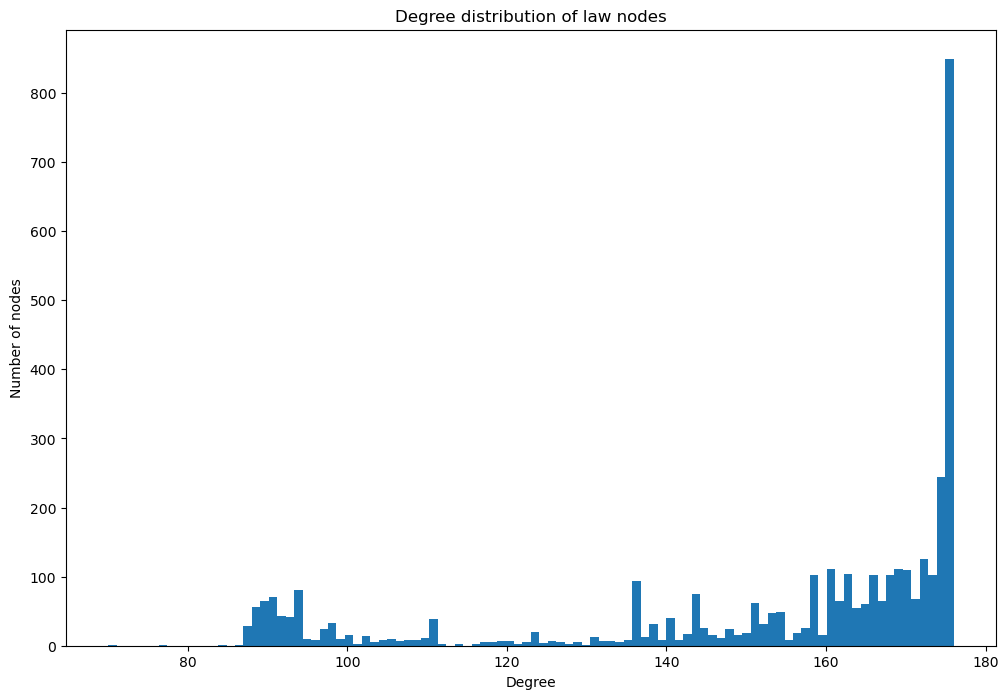

In [181]:
#Plot the degree distribution of nodes in the network
#Since we have a bipartite network with relatively few politcians, connecting each to hundreds of laws, we split the distribution of politician and law nodes seperately

#degree distribution of law nodes
#plot the degree distribution of the law nodes
plt.figure(figsize=(12,8))
plt.hist([G_bipartite.degree(node) for node in law_nodes], bins=100)
plt.title('Degree distribution of law nodes')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
#set size of the figure to 10x10

plt.show()

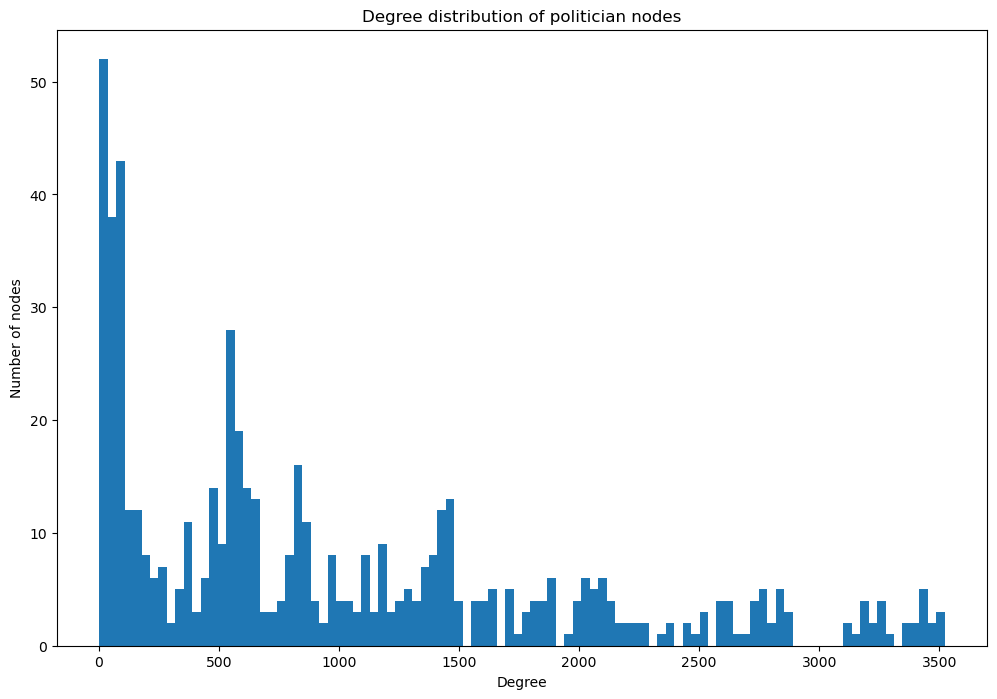

In [182]:
#plot degree distribution of politician nodes
plt.figure(figsize=(12,8))
plt.hist([G_bipartite.degree(node) for node in politician_nodes], bins=100)
plt.title('Degree distribution of politician nodes')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.show()


In [183]:
#Creates a weighted unipartite graph by projecting the bipartite graph onto the politician nodes
G_uni = nx.bipartite.weighted_projected_graph(G_bipartite, politician_nodes)


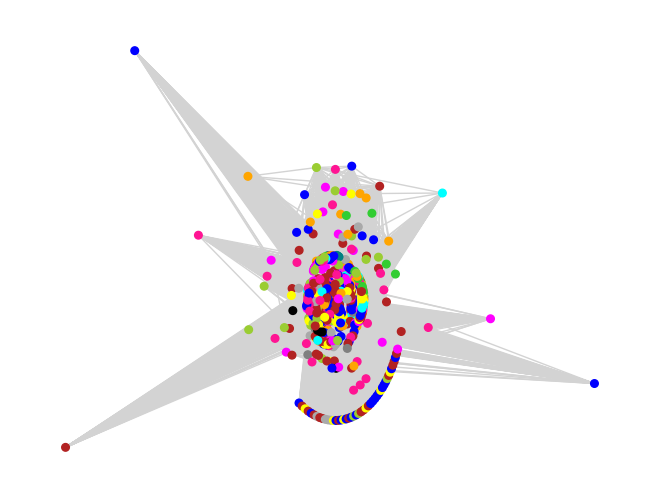

In [184]:
#draw the unipartite network with node attribute node as label using nx.draw_networkx

#node_names = nx.get_node_attributes(G_uni, 'name') 
#G_uni.remove_nodes_from(list(nx.isolates(G_uni)))
pos = nx.kamada_kawai_layout(G_uni)

nx.draw(G_uni, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()])

In [185]:
import matplotlib.patches as patches
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors

unique_parties = ['Tjóðveldisflokkurin', 'Tjóðveldi', 'Inuit Ataqatigiit', 'Socialdemokratiet', 'Nye Borgerlige', 'Dansk Folkeparti', 'Fólkaflokkurin', 'Moderaterne', 'Socialistisk Folkeparti', 'Javnaðarflokkurin', 'Kristendemokraterne', 'unknown', 'Enhedslisten', 'Nunatta Qitornai', 'Ny Alliance', 'Frie Grønne', 'Sambandsflokkurin', 'Det Konservative Folkeparti', 'Danmarksdemokraterne', 'Liberal Alliance', 'Siumut', 'Radikale Venstre', 'Uden for folketingsgrupperne', 'Venstre, Danmarks Liberale Parti', 'Alternativet']

degree_list = []
for node in G_uni.nodes():
    degree_list.append(G_uni.degree(node))

# normalize node size to highest degree with max size = 30
max_degree = max(degree_list)
node_size_list = [x/max_degree*200 for x in degree_list]

rgb = colors.to_rgba_array([color_map[party] for party in unique_parties])
rgb
handles_dict = {patches.Patch(color = rgb, label = party) for party, rgb in color_map.items()}


100%|██████████| 500/500 [00:13<00:00, 37.71it/s]


BarnesHut Approximation  took  1.19  seconds
Repulsion forces  took  3.60  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  8.07  seconds
AdjustSpeedAndApplyForces step  took  0.14  seconds


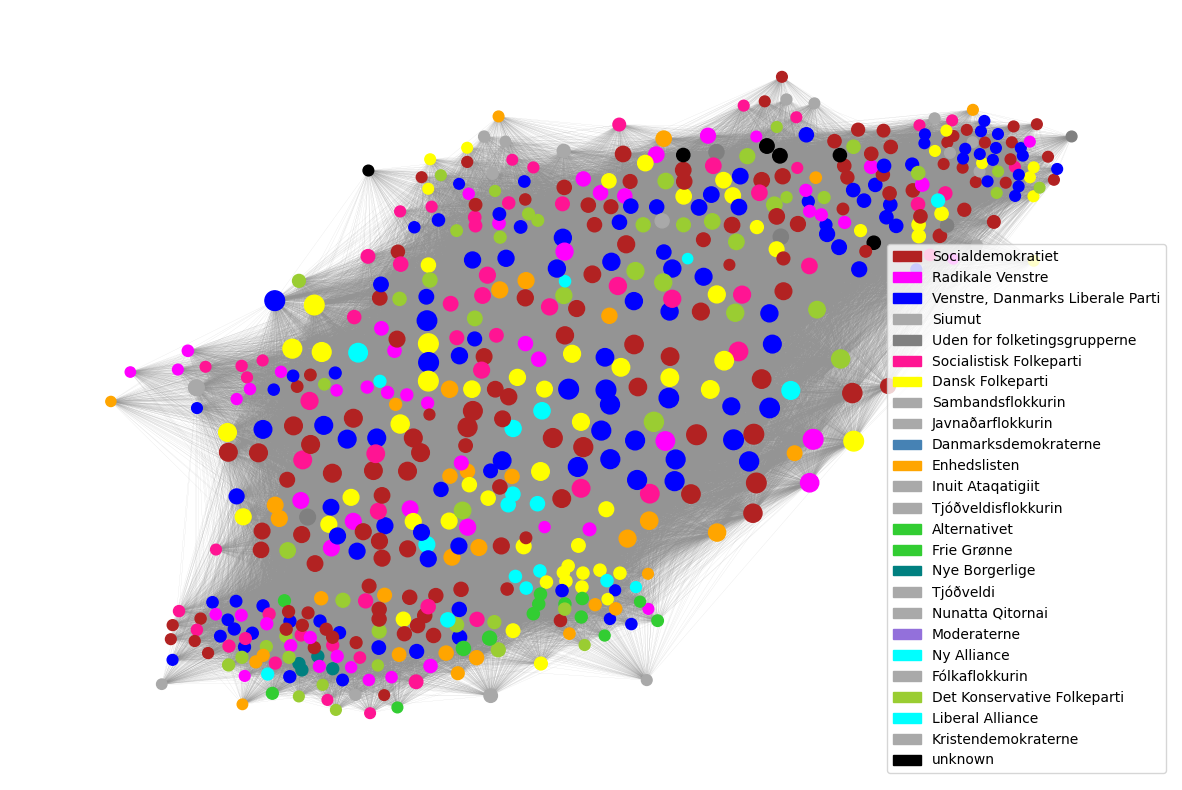

In [186]:

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=0.1,

    # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1,
                        strongGravityMode=False,
                        gravity=0.1,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(
    G_uni, pos=None, iterations=500)

fig, ax = plt.subplots(figsize=(15, 10))
nx.draw(G_uni, pos=positions, with_labels=False, node_size=node_size_list, node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes], labels = color_map.items(),
        width=0.05, edge_color='#949494')
ax.legend(handles = handles_dict)
